### Compute big mama npz files for all subjects

In [ ]:
from brainpipe.system import study
from os.path import isfile, join
import numpy as np
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt

###############################################################################
st = study('Olfacto')
path_npz = join(st.path,'feature/TPSim_{}_By_Odor_By_Cond/TPS_by_cond/')
tps_name = join(path_npz, 'TPS_spear_{}_cond_{}_{}.npz')
path2save = join(st.path, '_Figures_TPSim_paper/TPS_elecs_plots/')
exp = 'Enc' #should be identical with Ret files
freq, cond = 'theta','high' #same elecs whatever the freq or the cond
#OFC coordinates according to neurosynth (75 studies included)
x0,y0,z0 = 20, 30,-16
x1,y1,z1 = -20, 32,-16
rad = 13
subjects = ['CHAF','VACJ','SEMC','PIRJ','LEFC','FERJ']
###############################################################################

## Create a npz file with all sources informations
su_codes, s_xyz, s_elec = np.array([]),np.array([]), np.array([])
su_names, s_channels,s_labels, = np.array([]),np.array([]),np.array([])

for i,su in enumerate(sorted(subjects)):
    mat = np.load(tps_name.format(exp,su,cond,freq), allow_pickle=True)
#     print(mat.files)
    xyz_all = mat['xyz']
    for elec in range(xyz_all.shape[0]):
        
        ### INFO electrodes for all subjects
        su_names = np.vstack((su_names,su)) if np.size(su_names) else su
        su_codes = np.vstack((su_codes,'S'+str(i))) if np.size(su_codes) else 'S'+str(i)
        lab = mat['label'][elec]
        channel = mat['channel'][elec]               
        xyz = xyz_all[elec]
        
        ### REMOVE pHC and non-olf OFC electrodes
        x,y,z = xyz[0], xyz[1], xyz[2]
        id_R = 1 if all([x0-rad<=x<=x0+rad, y0-rad<=y<=y0+rad,
                z0-rad<=z<=z0+rad]) else 0
        id_L = 1 if all([x1-rad<=x<=x1+rad, y1-rad<=y<=y1+rad,
                z1-rad<=z<=z1+rad]) else 0
        idx = id_R + id_L
        lab = 'OFC_olf' if idx == 1 else lab
        lab = 'aHC' if lab == 'HC' and y > -26 else lab
        
        s_xyz = np.vstack((s_xyz, xyz)) if np.size(s_xyz) else xyz
        s_labels = np.vstack((s_labels, lab)) if np.size(s_labels) else lab
        s_channels = np.vstack((s_channels, channel)) if np.size(s_channels) else channel
        s_elec = np.vstack((s_elec,str(elec))) if np.size(s_elec) else str(elec)
        
su_names = np.squeeze(su_names)
su_codes = np.squeeze(su_codes)
s_labels = np.squeeze(s_labels)
s_channels = np.squeeze(s_channels)
s_elec = np.squeeze(s_elec)

su_coord_label = {'su_codes':su_codes,'su_names':su_names,'s_xyz':s_xyz,
                  's_labels':s_labels,'s_channels':s_channels,'s_elec':s_elec}

file_source = 'All_subjects_sources_TPS_elecs.npz'
np.savez(path2save+file_source,**su_coord_label)

### Plot the electrodes distribution

In [13]:
"""
Plot electrodes distribution by patients: for 6 patients including only electrodes
present both at encoding and retrieval
"""
from brainpipe.system import study
from os import makedirs
from os.path import isfile, join, exists
import numpy as np
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
from utils import rename_elecs

###############################################################################
st = study('Olfacto')
pathname = join(st.path,'database/Encoding_By_Odor/All_elecs_infos_npz/')
filename = join(pathname, 'All_subjects_sources_odor_low_high_sel_physFT.npz')
rois_to_keep = ['aHC','MFG','ACC','IFG','Amg','pPirT','PHG','Ins_olf',
            'OFC_olf','SFG']
###############################################################################

#Create the df summarizing all elecs infos
mat = np.load(filename,allow_pickle=True)
labels = mat['s_Mai_RL']
x,y,z = mat['s_xyz'][:,0], mat['s_xyz'][:,1], mat['s_xyz'][:,2]
labels_new = rename_elecs(labels,x,y,z)

id_rois = np.where([roi in rois_to_keep for roi in labels_new])

subjects,su_codes, s_labels = mat['su_names'][id_rois][:,np.newaxis],\
        mat['su_codes'][id_rois][:,np.newaxis], labels_new[id_rois][:,np.newaxis]
s_elec, s_channels = mat['s_elec'][id_rois][:,np.newaxis], \
        mat['s_channels'][id_rois][:,np.newaxis]
print(subjects.shape, su_codes.shape,s_elec.shape, s_channels.shape, s_labels.shape)
s_xyz = mat['s_xyz'][id_rois].swapaxes(0,1)
s_x, s_y, s_z = s_xyz[0][:,np.newaxis], s_xyz[1][:,np.newaxis],s_xyz[2][:,np.newaxis]
print(s_x.shape)

elec_data = np.concatenate((subjects,su_codes, s_elec, s_channels,s_labels, \
                            s_x, s_y,s_z),axis=1)
df0 = pd.DataFrame(elec_data, columns=['subjects','su_codes','elecs','channels',
                'labels','x','y','z'])
# Add information about the lobe of elecs
dict_regions ={ 'ACC':'Frontal','IFG':'Frontal','MFG':'Frontal','SFG':'Frontal',
                'Amg':'Olf','pPirT':'Olf','Amg-PirT':'Olf','Ins_olf':'Olf','OFC_olf':'Olf',
                'aHC':'MTL','PHG':'MTL','HC':'MTL'}
df0['region'] = df0['labels'].map(dict_regions)

dfname = '0_all_subjects_info_elecs_sel.csv'
df0.to_csv(pathname+dfname)

-> Olfacto loaded
(230, 1) (230, 1) (230, 1) (230, 1) (230, 1)
(230, 1)


          elecs
su_codes       
S0           61
S1           32
S2           27
S3           53
S4           18
S5           39 sel su_codes
S0    61
S1    32
S2    27
S3    53
S4    18
S5    39
Name: elecs, dtype: int64


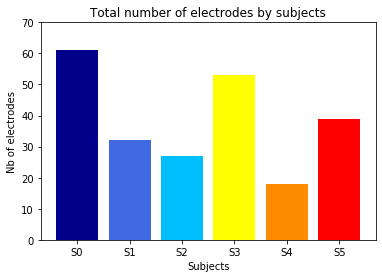

In [14]:
### PLOTS BY ROIs AND SUBJECTS
colors = {'S0':'darkblue', 'S1':'royalblue', 'S2':'deepskyblue', 'S3':'yellow',
          'S4':'darkorange', 'S5':'red'}

## total nb of electrodes by patient
elecs_su = df0[['su_codes','elecs']].groupby(['su_codes']).count()
print(elecs_su,'sel',elecs_su['elecs'])
fig = plt.figure()
plt.bar(range(len(elecs_su)), elecs_su['elecs'],
        color=[colors[i] for i,row in elecs_su.iterrows()])
plt.title('Total number of electrodes by subjects')
plt.ylabel('Nb of electrodes')
plt.xlabel('Subjects')
xticks_pos = np.arange(len(elecs_su))
plt.xticks(xticks_pos,list(elecs_su['elecs'].index.values))
plt.ylim(bottom=0, top=70)
plt.savefig(pathname+'Total_elec_by_patient.png')

In [15]:
TOTAL = 61+32+27+53+18+39
print(TOTAL)

230


labels
ACC         9.0
Amg         5.0
IFG        41.0
Ins_olf    12.0
MFG        40.0
OFC_olf    19.0
PHG         5.0
SFG        57.0
aHC        36.0
pPirT       6.0
dtype: float64
(0, 'S0') [ 3.  0.  0.  0. 14.  3.  0. 41.  0.  0.]
(1, 'S1') [ 0.  2.  4.  8.  0.  0.  0.  0. 14.  4.]
(2, 'S2') [0. 0. 3. 0. 5. 5. 0. 5. 8. 1.]
(3, 'S3') [ 4.  0. 17.  0. 13.  3.  0. 11.  5.  0.]
(4, 'S4') [0. 0. 4. 4. 0. 4. 5. 0. 1. 0.]
(5, 'S5') [ 2.  3. 13.  0.  8.  4.  0.  0.  8.  1.]


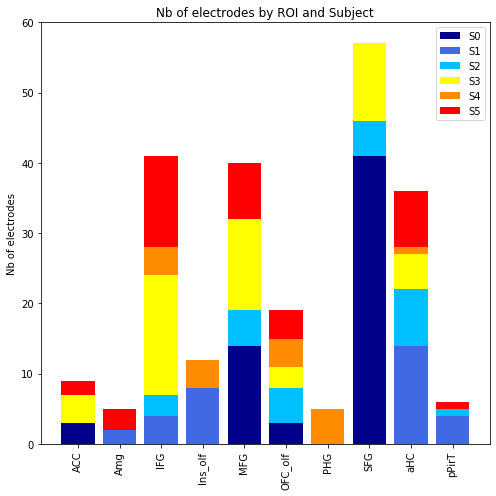

In [22]:
method = 'labels' #region, labels
elecs_su_roi = df0.groupby(['su_codes',method]).count()['elecs'].unstack()
elecs_su_roi = elecs_su_roi.fillna(0)
print(elecs_su_roi.sum())

#Plot nb of electrodes for each subjects
colors = {'S0':'darkblue', 'S1':'royalblue', 'S2':'deepskyblue', 'S3':'yellow',
          'S4':'darkorange', 'S5':'red'}
fig = plt.figure(figsize=(7,7))
bottom = np.zeros(len(elecs_su_roi.columns))
for s in enumerate(elecs_su_roi.index):
    count = elecs_su_roi.iloc[elecs_su_roi.index.get_level_values('su_codes') == s[1]].values[0]
    xpts = range(len(count))
    print(s,count)
    plt.bar(xpts, count, bottom=bottom, color=colors[s[1]], label=s[1])
    bottom += count

plt.title('Nb of electrodes by ROI and Subject')
plt.ylabel('Nb of electrodes')
plt.xticks(xpts,list(elecs_su_roi.columns.values),rotation=90)
plt.tight_layout()
plt.ylim(bottom=0, top=60)
plt.legend(loc='best')
plt.savefig(pathname+'Total_elec_by_patient_by_roi_'+method+'.png')
plt.savefig(pathname+'Total_elec_by_patient_by_roi_'+method+'.pdf')